In [368]:
import math
import numpy as np
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch import nn
from torch.nn.modules import Module
from torch.autograd import Variable
from torch.nn.modules import utils
import matplotlib.pyplot as plt
import imageio

In [8]:
fc1_w_init = None #np.random.randn(*fc1_w_init.shape)
fc1_b_init = None #np.random.randn(*fc1_b_init.shape)
fc2_w_init = None #np.random.randn(*fc2_w_init.shape)
fc2_b_init = None # np.random.randn(*fc2_b_init.shape)
fc3_w_init = None #np.random.randn(*fc3_w_init.shape)
fc3_b_init = None #np.random.randn(*fc3_b_init.shape)
# build a simple MLP

In [9]:
def reparametrize(mu, logvar, cuda=False, sampling=True):
    if sampling:
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return mu + eps * std
    else:
        return mu

In [10]:
# -------------------------------------------------------
# LINEAR LAYER
# -------------------------------------------------------

class LinearGroupNJ(Module):
    """Fully Connected Group Normal-Jeffrey's layer (aka Group Variational Dropout).

    References:
    [1] Kingma, Diederik P., Tim Salimans, and Max Welling. "Variational dropout and the local reparameterization trick." NIPS (2015).
    [2] Molchanov, Dmitry, Arsenii Ashukha, and Dmitry Vetrov. "Variational Dropout Sparsifies Deep Neural Networks." ICML (2017).
    [3] Louizos, Christos, Karen Ullrich, and Max Welling. "Bayesian Compression for Deep Learning." NIPS (2017).
    """

    def __init__(self, in_features, out_features, cuda=False, init_weight=None, init_bias=None, clip_var=None):

        super(LinearGroupNJ, self).__init__()
        self.cuda = cuda
        self.in_features = in_features
        self.out_features = out_features
        self.clip_var = clip_var
        self.deterministic = False  # flag is used for compressed inference
        # trainable params according to Eq.(6)
        # dropout params
        self.z_mu = Parameter(torch.Tensor(in_features))
        self.z_logvar = Parameter(torch.Tensor(in_features))  # = z_mu^2 * alpha
        # weight params
        self.weight_mu = Parameter(torch.Tensor(out_features, in_features))
        self.weight_logvar = Parameter(torch.Tensor(out_features, in_features))

        self.bias_mu = Parameter(torch.Tensor(out_features))
        self.bias_logvar = Parameter(torch.Tensor(out_features))

        # init params either random or with pretrained net
        self.reset_parameters(init_weight, init_bias)

        # activations for kl
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()

        # numerical stability param
        self.epsilon = 1e-8

    def reset_parameters(self, init_weight, init_bias):
        # init means
        stdv = 1. / math.sqrt(self.weight_mu.size(1))

        self.z_mu.data.normal_(1, 1e-2)

        if init_weight is not None:
            self.weight_mu.data = torch.Tensor(init_weight)
        else:
            self.weight_mu.data.normal_(0, stdv)

        if init_bias is not None:
            self.bias_mu.data = torch.Tensor(init_bias)
        else:
            self.bias_mu.data.fill_(0)

        # init logvars
        self.z_logvar.data.normal_(-9, 1e-2)
        self.weight_logvar.data.normal_(-9, 1e-2)
        self.bias_logvar.data.normal_(-9, 1e-2)

    def clip_variances(self):
        if self.clip_var:
            self.weight_logvar.data.clamp_(max=math.log(self.clip_var))
            self.bias_logvar.data.clamp_(max=math.log(self.clip_var))

    def get_log_dropout_rates(self):
        log_alpha = self.z_logvar - torch.log(self.z_mu.pow(2) + self.epsilon)
        return log_alpha

    def compute_posterior_params(self):
        weight_var, z_var = self.weight_logvar.exp(), self.z_logvar.exp()
        self.post_weight_var = self.z_mu.pow(2) * weight_var + z_var * self.weight_mu.pow(2) + z_var * weight_var
        self.post_weight_mu = self.weight_mu * self.z_mu
        return self.post_weight_mu, self.post_weight_var

    def forward(self, x):
        if self.deterministic:
            assert self.training == False, "Flag deterministic is True. This should not be used in training."
            return F.linear(x, self.post_weight_mu, self.bias_mu)

        batch_size = x.size()[0]
        # compute z  
        # note that we reparametrise according to [2] Eq. (11) (not [1])
        z = reparametrize(self.z_mu.repeat(batch_size, 1), self.z_logvar.repeat(batch_size, 1), sampling=self.training,
                          cuda=self.cuda)

        # apply local reparametrisation trick see [1] Eq. (6)
        # to the parametrisation given in [3] Eq. (6)
        xz = x * z
        mu_activations = F.linear(xz, self.weight_mu, self.bias_mu)
        var_activations = F.linear(xz.pow(2), self.weight_logvar.exp(), self.bias_logvar.exp())

        return reparametrize(mu_activations, var_activations.log(), sampling=self.training, cuda=self.cuda)

    def kl_divergence(self):
        # KL(q(z)||p(z))
        # we use the kl divergence approximation given by [2] Eq.(14)
        k1, k2, k3 = 0.63576, 1.87320, 1.48695
        log_alpha = self.get_log_dropout_rates()
        KLD = -torch.sum(k1 * self.sigmoid(k2 + k3 * log_alpha) - 0.5 * self.softplus(-log_alpha) - k1)

        # KL(q(w|z)||p(w|z))
        # we use the kl divergence given by [3] Eq.(8)
        KLD_element = -0.5 * self.weight_logvar + 0.5 * (self.weight_logvar.exp() + self.weight_mu.pow(2)) - 0.5
        KLD += torch.sum(KLD_element)

        # KL bias
        KLD_element = -0.5 * self.bias_logvar + 0.5 * (self.bias_logvar.exp() + self.bias_mu.pow(2)) - 0.5
        KLD += torch.sum(KLD_element)

        return KLD

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


In [100]:
# build a simple MLP
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # activation
        self.relu = nn.ReLU()
        # layers
        self.fc1 = LinearGroupNJ(28 * 28, 300, clip_var=0.04, init_weight=fc1_w_init, init_bias=fc1_b_init, cuda=False)
        self.fc2 = LinearGroupNJ(300, 100,init_weight=fc2_w_init, init_bias=fc2_b_init, cuda=False)
        self.fc3 = LinearGroupNJ(100, 10,init_weight=fc3_w_init, init_bias=fc3_b_init, cuda=False)
        # layers including kl_divergence
        self.kl_list = [self.fc1, self.fc2, self.fc3]

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

    def get_masks(self,thresholds):
        weight_masks = []
        mask = None
        for i, (layer, threshold) in enumerate(zip(self.kl_list, thresholds)):
            # compute dropout mask
            if mask is None:
                log_alpha = layer.get_log_dropout_rates().cpu().data.numpy()
                mask = log_alpha < threshold
            else:
                mask = np.copy(next_mask)
            try:
                log_alpha = layers[i + 1].get_log_dropout_rates().cpu().data.numpy()
                next_mask = log_alpha < thresholds[i + 1]
            except:
                # must be the last mask
                next_mask = np.ones(10)
            print('Layer:'+str(i))
            print('Current layer log alpha length:'+str(mask.shape))
            print('Next layer log alpha length:'+str(next_mask.shape))
            weight_mask = np.expand_dims(mask, axis=0) * np.expand_dims(next_mask, axis=1)
            weight_masks.append(weight_mask.astype(np.float))
        return weight_masks

    def kl_divergence(self):
        KLD = 0
        for layer in self.kl_list:
            KLD += layer.kl_divergence()
        return KLD

# init model
model = Net()

In [757]:
epoch = 15


In [758]:
ckpt = torch.load('epoch'+str(epoch)+'bcdl_pretrained.pt',map_location=torch.device('cpu'))
model.load_state_dict(ckpt)

<All keys matched successfully>

In [759]:
layers = [model.fc1, model.fc2, model.fc3]

In [760]:
thresholds = [-2.8, -3., -5.]

In [761]:
masks = model.get_masks(thresholds)

Layer:0
Current layer log alpha length:(784,)
Next layer log alpha length:(300,)
Layer:1
Current layer log alpha length:(300,)
Next layer log alpha length:(100,)
Layer:2
Current layer log alpha length:(100,)
Next layer log alpha length:(10,)


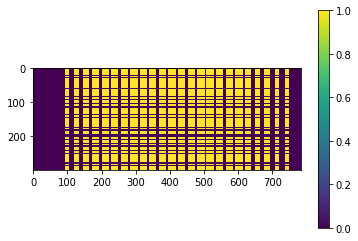

In [762]:
plt.imshow(masks[0])
plt.colorbar()
plt.show()

In [763]:
weight_mus = [model.fc1.weight_mu, model.fc2.weight_mu, model.fc3.weight_mu]; #import pdb; pdb.set_trace()
log_alphas = [model.fc1.get_log_dropout_rates(), model.fc2.get_log_dropout_rates(), model.fc3.get_log_dropout_rates()]

In [764]:
def visualise_weights(weight_mus, log_alphas, layer):


    i = layer
    f, ax = plt.subplots(1, 1)
    weight_mu = (weight_mus[i].cpu().data.numpy())
    # alpha
    log_alpha_fc1 = log_alphas[i].unsqueeze(0).cpu().data.numpy()
    log_alpha_fc1 = log_alpha_fc1 < thresholds[i]
    try:
        log_alpha_fc2 = log_alphas[i + 1].unsqueeze(1).cpu().data.numpy()
        log_alpha_fc2 = log_alpha_fc2 < thresholds[i+1]
    except:
        log_alpha_fc2 = np.ones((10,1))
    mask = log_alpha_fc1 * log_alpha_fc2
    num_nz = (mask>0).sum()
    tot_num = mask.shape[0] * mask.shape[1]
    ratio_z = 1-(num_nz/tot_num)
    # weight
    c = np.max(np.abs(weight_mu))
    s = ax.imshow(weight_mu * mask, cmap='seismic', interpolation='none', vmin=-c, vmax=c)
    ax.grid("off")
    ax.set_yticks([])
    ax.set_xticks([])
    s.set_clim([-c * 0.5, c * 0.5])
    f.colorbar(s)
    plt.title('Ratio of zeros:%.2f'%(ratio_z))
    

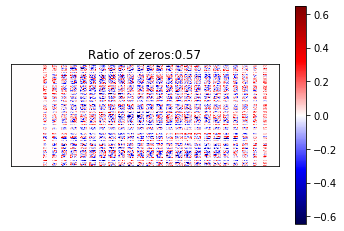

In [765]:
visualise_weights(weight_mus,log_alphas,0)

In [766]:
def visualise_weights_fullNet(weight_mus, log_alphas, epoch,sav_name):
    num_layers = len(weight_mus)

    for i in range(num_layers):
        f, ax = plt.subplots(1, 1)
        weight_mu = (weight_mus[i].cpu().data.numpy())
        # alpha
        log_alpha_fc1 = log_alphas[i].unsqueeze(0).cpu().data.numpy()
        log_alpha_fc1 = log_alpha_fc1 < thresholds[i]
        try:
            log_alpha_fc2 = log_alphas[i + 1].unsqueeze(1).cpu().data.numpy()
            log_alpha_fc2 = log_alpha_fc2 < thresholds[i+1]
        except:
            log_alpha_fc2 = np.ones((10,1))
        mask = log_alpha_fc1 * log_alpha_fc2
        num_nz = (mask>0).sum()
        tot_num = mask.shape[0] * mask.shape[1]
        ratio_z = 1-(num_nz/tot_num)
        # weight
        c = np.max(np.abs(weight_mu))
        s = ax.imshow(weight_mu * mask, cmap='seismic', interpolation='none', vmin=-c, vmax=c)
        ax.grid("off")
        ax.set_yticks([])
        ax.set_xticks([])
        s.set_clim([-c * 0.5, c * 0.5])
        f.colorbar(s)
        plt.title("Epoch:" + str(epoch)+', ratio of zeros:%.2f'%(ratio_z))
        plt.savefig(sav_name + str(i) + '_e' + str(epoch) + ".png", bbox_inches='tight')
        plt.close()

In [767]:
def generate_gif(save='tmp', epochs=10):
    images = []
    filenames = [save + "%d.png" % (epoch) for epoch in [3,6,9,12,15]]
    for filename in filenames:
        images.append(imageio.imread(filename))
        #os.remove(filename)
    imageio.mimsave('./figures/' + save + '.gif', images, duration=.5)

In [768]:
sav_name = 'pretrained_weight'
visualise_weights_fullNet(weight_mus, log_alphas, epoch,sav_name)


In [771]:
generate_gif(sav_name+'0_e', epoch)

In [773]:
model.kl_divergence()

tensor(296698.5312, grad_fn=<AddBackward0>)

In [353]:
#layer 1 Not sure about the following part!!!
var_w = model.fc1.weight_logvar.exp()
mu_w = model.fc1.weight_mu
var_z = model.fc1.z_logvar.exp()
mu_z = model.fc1.z_mu

i=56;j=45
var_zi = var_z[i].detach().numpy()
mu_zi = mu_z[i].detach().numpy()
var_wij = var_w[i,j].detach().numpy()
mu_wij = mu_w[i,j].detach().numpy()
no_samples = 1000


In [354]:
zi_samples = math.sqrt(var_zi)*np.random.randn(no_samples) + mu_zi

In [355]:
new_mu = (mu_wij*zi_samples)
new_sigma = np.power(var_wij*(np.power(zi_samples,2)),0.5)

In [356]:
wij_samples = new_sigma*(np.random.randn(len(new_mu))) + new_mu

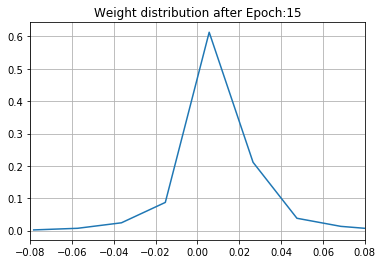

In [357]:
hist = np.histogram(wij_samples,10)
pdf = hist[0]/np.sum(hist[0])
plt.plot(hist[1][1:],pdf)
plt.grid('on')
plt.xlim(-0.08,0.08)
plt.title('Weight distribution after Epoch:'+str(epoch))
plt.savefig('WD_epoch'+str(epoch)+'png',bbox_inches='tight')

In [776]:
def unit_round_off(t=23):
    """
    :param t:
        number significand bits
    :return:
        unit round off based on nearest interpolation, for reference see [1]
    """
    return 0.5 * 2. ** (1. - t)


SIGNIFICANT_BIT_PRECISION = [unit_round_off(t=i + 1) for i in range(23)]


def float_precision(x):

    out = np.sum([x < sbp for sbp in SIGNIFICANT_BIT_PRECISION])
    return out


def float_precisions(X, dist_fun, layer=1):

    X = X.flatten()
    out = [float_precision(2 * x) for x in X]
    out = np.ceil(dist_fun(out))
    return out


def special_round(input, significant_bit):
    delta = unit_round_off(t=significant_bit)
    rounded = np.floor(input / delta + 0.5)
    rounded = rounded * delta
    return rounded


def fast_infernce_weights(w, exponent_bit, significant_bit):

    return special_round(w, significant_bit)


def compress_matrix(x):

    if len(x.shape) != 2:
        A, B, C, D = x.shape
        x = x.reshape(A * B,  C * D)
        # remove non-necessary filters and rows
        x = x[:, (x != 0).any(axis=0)]
        x = x[(x != 0).any(axis=1), :]
    else:
        # remove unnecessary rows, columns
        x = x[(x != 0).any(axis=1), :]
        x = x[:, (x != 0).any(axis=0)]
    return x


def extract_pruned_params(layers, masks):

    post_weight_mus = []
    post_weight_vars = []

    for i, (layer, mask) in enumerate(zip(layers, masks)):
        # compute posteriors
        post_weight_mu, post_weight_var = layer.compute_posterior_params()
        post_weight_var = post_weight_var.cpu().data.numpy()
        post_weight_mu  = post_weight_mu.cpu().data.numpy()
        # apply mask to mus and variances
        post_weight_mu  = post_weight_mu * mask
        post_weight_var = post_weight_var * mask

        post_weight_mus.append(post_weight_mu)
        post_weight_vars.append(post_weight_var)

    return post_weight_mus, post_weight_vars


# -------------------------------------------------------
#  Compression rates (fast inference scenario)
# -------------------------------------------------------


def _compute_compression_rate(vars, in_precision=32., dist_fun=lambda x: np.max(x), overflow=10e38):
    # compute in  number of bits occupied by the original architecture
    sizes = [v.size for v in vars]
    nb_weights = float(np.sum(sizes))
    IN_BITS = in_precision * nb_weights
    # prune architecture
    vars = [compress_matrix(v) for v in vars]
    sizes = [v.size for v in vars]
    # compute
    significant_bits = [float_precisions(v, dist_fun, layer=k + 1) for k, v in enumerate(vars)]
    exponent_bit = np.ceil(np.log2(np.log2(overflow) + 1.) + 1.)
    total_bits = [1. + exponent_bit + sb for sb in significant_bits]
    OUT_BITS = np.sum(np.asarray(sizes) * np.asarray(total_bits))
    return nb_weights / np.sum(sizes), IN_BITS / OUT_BITS, significant_bits, exponent_bit


def compute_compression_rate(layers, masks):
    # reduce architecture
    weight_mus, weight_vars = extract_pruned_params(layers, masks)
    # compute overflow level based on maximum weight
    overflow = np.max([np.max(np.abs(w)) for w in weight_mus])
    # compute compression rate
    CR_architecture, CR_fast_inference, _, _ = _compute_compression_rate(weight_vars, dist_fun=lambda x: np.mean(x), overflow=overflow)
    print("Compressing the architecture will degrease the model by a factor of %.1f." % (CR_architecture))
    print("Making use of weight uncertainty can reduce the model by a factor of %.1f." % (CR_fast_inference))


def compute_reduced_weights(layers, masks):
    weight_mus, weight_vars = extract_pruned_params(layers, masks)
    overflow = np.max([np.max(np.abs(w)) for w in weight_mus])
    _, _, significant_bits, exponent_bits = _compute_compression_rate(weight_vars, dist_fun=lambda x: np.mean(x), overflow=overflow)
    weights = [fast_infernce_weights(weight_mu, exponent_bits, significant_bit) for weight_mu, significant_bit in
               zip(weight_mus, significant_bits)]
    return weights

In [778]:
layers = [model.fc1, model.fc2, model.fc3]
compute_compression_rate(layers, model.get_masks(thresholds))

Layer:0
Current layer log alpha length:(784,)
Next layer log alpha length:(300,)
Layer:1
Current layer log alpha length:(300,)
Next layer log alpha length:(100,)
Layer:2
Current layer log alpha length:(100,)
Next layer log alpha length:(10,)
Compressing the architecture will degrease the model by a factor of 2.3.
Making use of weight uncertainty can reduce the model by a factor of 9.0.


In [779]:
weights = compute_reduced_weights(layers, model.get_masks(thresholds))

Layer:0
Current layer log alpha length:(784,)
Next layer log alpha length:(300,)
Layer:1
Current layer log alpha length:(300,)
Next layer log alpha length:(100,)
Layer:2
Current layer log alpha length:(100,)
Next layer log alpha length:(10,)


In [783]:
weights

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[-0.0625 ,  0.     , -0.03125, ..., -0.03125,  0.0625 ,  0.     ],
        [-0.15625,  0.     ,  0.03125, ...,  0.03125, -0.15625,  0.     ],
        [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
        ...,
        [ 0.21875,  0.     , -0.03125, ..., -0.28125, -0.125  ,  0.     ],
        [-0.21875,  0.     , -0.0625 , ...,  0.0625 , -0.0625 ,  0.     ],
        [-0.03125,  0.     ,  0.0625 , ...,  0.09375, -0.0625 ,  0.     ]]),
 array([[-0.05664062, -0.01464844,  0.        ,  0.        ,  0.        ,
         -0.03222656,  0.        ,  0.        , -0.07421875,  0.10449219,
          0.06347656, -0.08691406,  0.        ,  0.        ,  0.        ,
          0.01660156,  0.01757812,  0.        ,  0.        ,  0.